In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import random
import cv2
import matplotlib.pyplot as plt
import math

import copy
from scipy import ndimage

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
# def open_image(fn):
#     flags = cv2.IMREAD_UNCHANGED+cv2.IMREAD_ANYDEPTH+cv2.IMREAD_ANYCOLOR
#     im = cv2.imread(str(fn), flags).astype(np.float32)
#     return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

In [3]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

In [4]:
style_im = read_image('/home/ubuntu/deep-learning/images/starry-night.jpg')
content_im = read_image('/home/ubuntu/deep-learning/images/content.jpg')

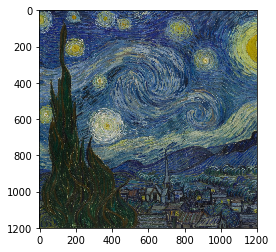

In [5]:
plt.imshow(style_im)

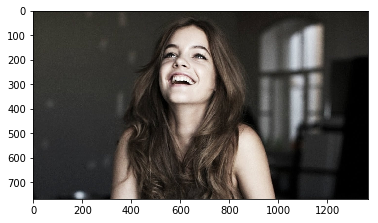

In [6]:
plt.imshow(content_im)

Making images to equal size to ease 

In [7]:
def center_crop(im, min_sz=None):
    """ Returns a center crop of an image"""
    r,c,*_ = im.shape
    if min_sz is None: min_sz = min(r,c)
    start_r = math.ceil((r-min_sz)/2)
    start_c = math.ceil((c-min_sz)/2)
    return crop(im, start_r, start_c, min_sz, min_sz)

def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

In [8]:
style_im = center_crop(style_im)
style_im = cv2.resize(style_im, (400, 400))
content_im = center_crop(content_im)
content_im = cv2.resize(content_im, (400, 400))

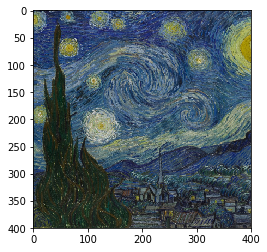

In [9]:
plt.imshow(style_im)

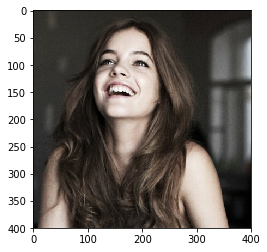

In [10]:
plt.imshow(content_im)

In [11]:
style_im.shape, content_im.shape

((400, 400, 3), (400, 400, 3))

In [12]:
def transform_images(im):
    """ Transform images to be ready for pre-trained network as 
        we need n_batch, n_channels, h,w format
    """
    im = np.rollaxis(im, 2)
    im = im[None]
    return torch.tensor(im, dtype=torch.float32).cuda()

In [13]:
style_img = transform_images(style_im/255)
content_img = transform_images(content_im/255)

In [14]:
style_img.shape, content_img.shape

(torch.Size([1, 3, 400, 400]), torch.Size([1, 3, 400, 400]))

### Style Transfer

In [15]:
def get_im_opt():
    opt_img = np.random.uniform(0, 1, size=content_im.shape).astype(np.float32)
    opt_img = ndimage.filters.median_filter(opt_img, [8,8,1])
    im_opt = transform_images(opt_img)
    im_opt.requires_grad=True
    optimizer = optim.LBFGS([im_opt], lr=0.01)
    return im_opt, optimizer

In [16]:
class inception_net(nn.Module):
    def __init__(self):
        """Select conv1_1 ~ conv5_1 activation maps."""
        super(inception_net, self).__init__()
        inc = models.inception_v3(pretrained=True).cuda().eval()
        inc.Conv2d_1a_3x3.conv.stride = (1,1)
        inc_model = nn.Sequential(*list(inc.children())[:11])
        for p in list(inc_model.parameters()):
            p.requires_grad = False
        self.select = ['5', '7', '10']
        self.inc_model = inc_model
        
    def forward(self, x):
        """Extract multiple convolutional feature maps."""
        features = []
        for name, layer in self.inc_model._modules.items():
            x = layer(x)
            if name in self.select:
                features.append(x)
        return features

In [17]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # unrolling feature maps

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [18]:
inc_net = inception_net()

In [19]:
im_style_f = inc_net(style_img)

In [20]:
[o.shape for o in im_style_f]

[torch.Size([1, 256, 394, 394]),
 torch.Size([1, 288, 394, 394]),
 torch.Size([1, 768, 196, 196])]

In [21]:
# gram matrix of style image
targ_g = [gram_matrix(f).detach() for f in im_style_f]
[o.shape for o in targ_g]

[torch.Size([256, 256]), torch.Size([288, 288]), torch.Size([768, 768])]

In [22]:
def train_style_transfer(optimizer, targ_g, targ_v, im_opt, iters, weights, alpha):
    """weight layers differently for style"""
    for i in range(iters):
        # constrain image to be between (0,1)
        im_opt.data.clamp_(0, 1)
        optimizer.zero_grad()
        # run the model
        out = inc_net(im_opt)
        input_g = [gram_matrix(f) for f in out]
        losses = [F.mse_loss(o, t)*w for o,t,w in zip(input_g, targ_g, weights)]
        loss = sum(losses)*1000*alpha
        if i%10 == 0: print('style loss:', loss.item())
        content_loss = F.mse_loss(out[0], targ_v.detach())
        if i%10 == 0: print('content_loss: ', content_loss.item())
        loss += content_loss
        loss.backward()
        if i%10 == 0: print('Epoch: ', i,'|', loss.item())
        optimizer.step()
    im_opt.data.clamp_(0, 1)
    return im_opt

In [23]:
# def train_style_transfer(optimizer, targ_g, targ_v, im_opt, iters, weights, alpha=1):
#     for i in range(iters):
#         def closure():
#             # constrain image to be between (0,1)
#             im_opt.data.clamp_(0, 1)
#             optimizer.zero_grad()
#             # run the model
#             out = inc_net(im_opt)
#             input_g = [gram_matrix(f) for f in out]
#             losses = [F.mse_loss(o, t) for o,t in zip(input_g, targ_g)]
#             loss = sum(losses)*alpha*100
#             loss += F.mse_loss(out[0], targ_v.detach())
#             loss.backward()
#             if i%10 == 0: print(loss.item())
#             return loss
#         optimizer.step(closure)
#     im_opt.data.clamp_(0, 1)
#     return im_opt

In [24]:
im_content = transform_images(content_im/255)
im_style = transform_images(style_im/255)
im_content.shape, im_style.shape

(torch.Size([1, 3, 400, 400]), torch.Size([1, 3, 400, 400]))

In [25]:
inc_net = inception_net()
im_style_f = inc_net(im_style)
targ_g = [gram_matrix(f).detach() for f in im_style_f]

In [26]:
im_content_f = inc_net(im_content)
targ_v = im_content_f[0].detach()
targ_v.shape

torch.Size([1, 256, 394, 394])

In [27]:
for f in im_content_f:
    print(f.shape)

torch.Size([1, 256, 394, 394])
torch.Size([1, 288, 394, 394])
torch.Size([1, 768, 196, 196])


In [28]:
im_opt, optimizer = get_im_opt()

In [29]:
optimizer = optim.Adam([im_opt], lr=.1)
im_opt = train_style_transfer(optimizer, targ_g, targ_v, im_opt, 200,
                              weights=[1,1,1], alpha=1000)

style loss: 0.8221057057380676
content_loss:  0.13298046588897705
Epoch:  0 | 0.9550861716270447
style loss: 0.41670113801956177
content_loss:  0.28625059127807617
Epoch:  10 | 0.7029517292976379
style loss: 0.11712481826543808
content_loss:  0.21022267639636993
Epoch:  20 | 0.3273474872112274
style loss: 0.036552898585796356
content_loss:  0.15405845642089844
Epoch:  30 | 0.1906113624572754
style loss: 0.018583260476589203
content_loss:  0.11814169585704803
Epoch:  40 | 0.13672494888305664
style loss: 0.013203760609030724
content_loss:  0.09767121821641922
Epoch:  50 | 0.11087498068809509
style loss: 0.011941946111619473
content_loss:  0.08640260249376297
Epoch:  60 | 0.09834454953670502
style loss: 0.011435601860284805
content_loss:  0.08024923503398895
Epoch:  70 | 0.09168483316898346
style loss: 0.02391907386481762
content_loss:  0.07689535617828369
Epoch:  80 | 0.10081443190574646
style loss: 0.011150499805808067
content_loss:  0.0760270431637764
Epoch:  90 | 0.08717754483222961
s

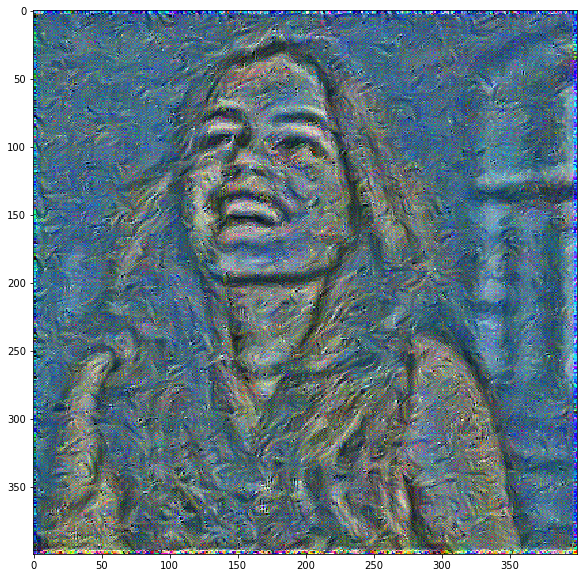

In [31]:
x = im_opt.cpu().detach().numpy()
x = np.rollaxis(x[0],0,3)
plt.figure(figsize=(10,10))
plt.imshow(x)

In [ ]:
# plt.imsave("art_barbara.jpg")

In [ ]:
# from IPython.display import FileLink

In [ ]:
# FileLink('art_barbara.jpg')

Can't make much better using inception and vgg works better. 

### End